# Understand RNA velocity

One of the most fancy yet technical recent innovation in the single-cell RNA-seq studies is RNA velocity (Gioele et al., 2018). By studying the transcription-splicing-degradation system rather than simply focus on the cumulative level of transcription, the velocity method could use information hidden previously in the unmapped reads. More recently, similar concept was extended to scSLAM-seq (Xiaojie et al., 2019), which provides extra RNA metabolism information by differentiate newly transcribed RNA strands from existing ones, in respect to a given time point. The author of scSLAM-seq claims that this extra piece of information could help to inference more parameters in the RNA velocity model. 

To get an idea of 
- what is RNA velocity, 
- how to formulate a model from which RNA velocity could be derived from and 
- how to solve the seemingly intricate equations to get the RNA velocity
- what's the usage of RNA velocity

Let's go through this technical snippet.

## What is RNA velocity
RNA velocity of a single cell specifies its movement trend on the gene expression space. In the gene expresssion space, each cell can be represented using a vector of it's RNA expression values. The transition from a cell type to another can be quantified by the change of the vector.

If we are about to trace the RNA transcription event continuously, a cell undergo a transcription program change (differentiation, stimulation, etc.) can be represented as a curve in the gene expression space. Each point on that curve move along the direction of its tangent line, which is an analog to the velocity.

In mathmatical words, RNA velocity is the first derivative of cell movement in the gene expression space. Similarly, we can also define RNA accelaration, which would be the second derivative of cell movement.

## What determines RNA velocity?
The answer is simple: anything that changes the value of that 'cell vector' determines RNA velocity. Specifically, in the RNA velocity paper, that includes:
- Generation of RNA $\rightarrow$ Unspliced RNA (Product)
- Splicing of RNA  $\rightarrow$ Spliced RNA (Product)
- Degradation of RNA  $\rightarrow$ NULL
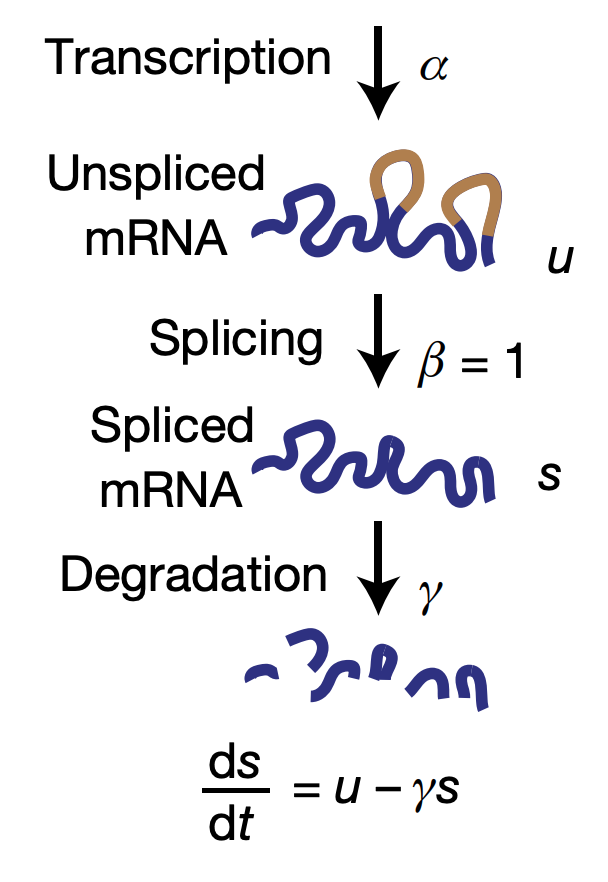


Notice that what the model includes is usually determined by what data do you have. For example, the 'dynamo' paper which uses scSLAM-seq data have extra information of 'new' and 'old' RNAs, thus their model is a bit more complex:
The RNA synthesis may use 4sU or U, resulting in two different states of transcribed RNA. Splicing also applies to both new and old transcribed RNAs. For newly transcribed RNA, the 4sU label might be cutted out from exon, creating more complexity. The full model looks like this:

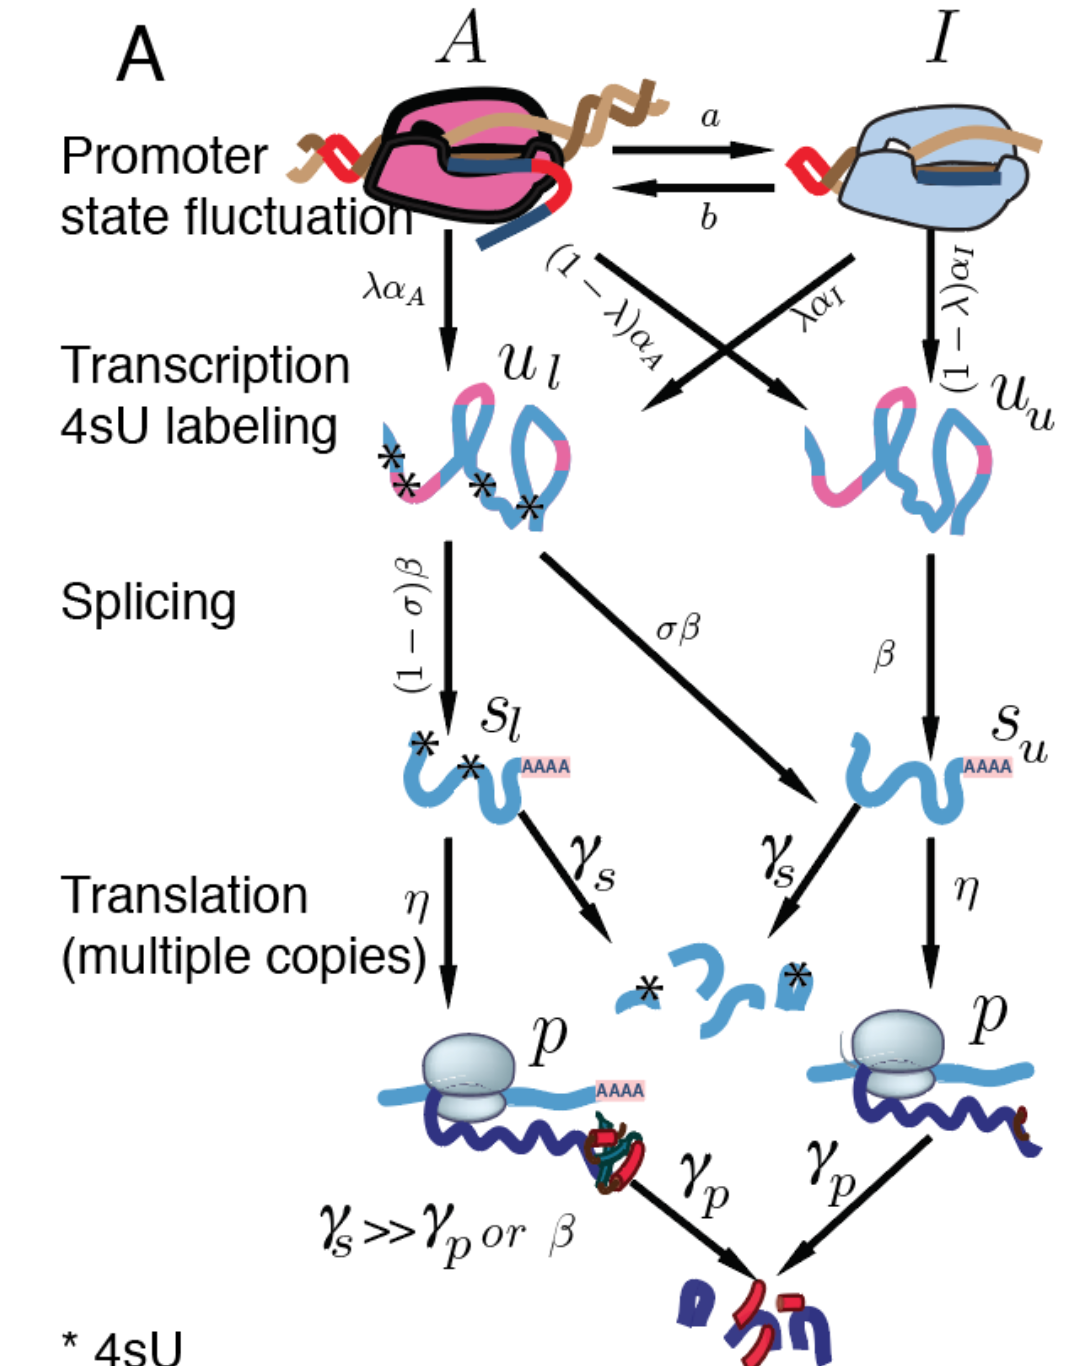

## Rate equations
Rate equations depict the relationship between reaction rate and the corresponding substrates/products. For example, in the RNA velocity example:

Change of unspliced RNA: $$\displaystyle\frac{d u  }{d t  }   =   \alpha  -u \left( t  \right)$$
Change of spliced RNA: $$ \displaystyle\frac{d s  }{d t  }   =  u \left( t  \right)  - \gamma  s \left( t  \right)$$ are rate equations which are first order linear ODEs. 

Note that this is a system of two linear ODEs, and should be solved easily under the assumption that $\alpha$(PolII transcription rate) is a constant. 

*Hint: what function is same to it's derivative?* --- Exponential function!
$$u(t) = e^t$$
Correspondingly, if 

$$u(t)=e^{-t}$$

then 
$$u'(t) = -e^{-t}$$

Since $$u(t)  = \alpha - u'(t)$$

We then have

$$u(t) = e^{-t} + \alpha$$

what about the other? Well we can do that use brain, but it's also possible to let computer do that for us. There are many tools that support symbolic math, e.g. the famous but pricy Mathematica or our open-source alternative, **sympy**.

In [55]:
# let's start from the first ODE, which is rather simple. U is u_0
from sympy import Function, dsolve, Eq, Derivative, symbols, exp
from sympy.abc import t,alpha, gamma, c
u = Function("u")
u_0 = symbols("u_0")
s_0 = symbols("s_0")
u_ = Derivative(u(t), t)
eq = u_ + u(t) - alpha

u_solved = dsolve(eq, u(t), ics={u(0): u_0})
u_solved

Eq(u(t), alpha + (-alpha + u_0)*exp(-t))


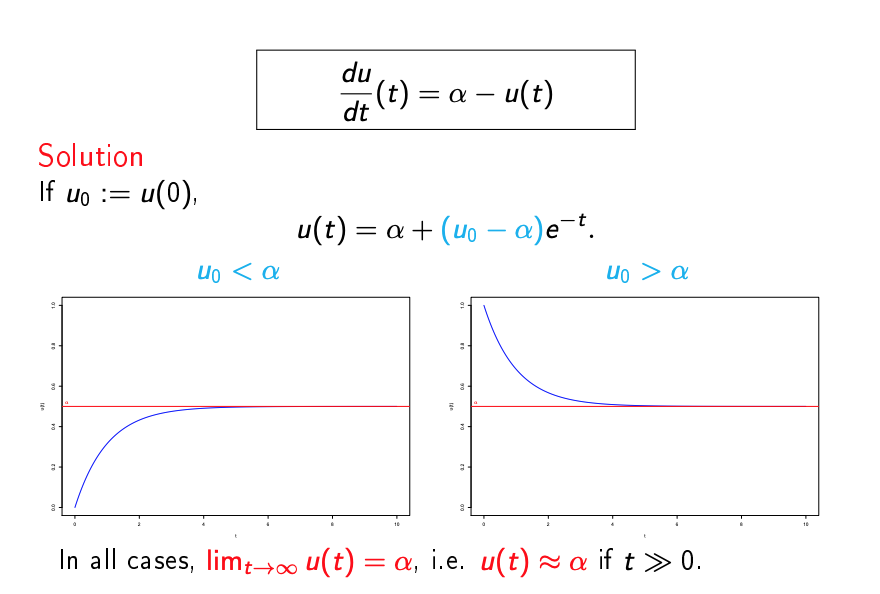

What about the another ODE? 

$$\displaystyle\frac{d s  }{d t  }   =  u \left( t  \right)  - \gamma  s \left( t  \right) $$

We can plugin the result of $u(t)$ to calculate $s(t)$

In [56]:
s = Function("s")
s_ = Derivative(s(t), t)
eq2 = -gamma*s(t) - s_ + alpha + (u_0 - alpha)*exp(-t)
s_solved = dsolve(eq2, ics={s(0):s_0})
s_solved

Eq(s(t), (Piecewise((-alpha + s_0 + u_0, Eq(gamma, 0)), (-alpha + s_0, Eq(gamma, 1)), (s_0 - (-alpha + gamma*u_0)/(gamma*(gamma - 1)), True)) + Piecewise((alpha*t + alpha*exp(-t) - u_0*exp(-t), Eq(gamma, 0)), (-alpha*t + alpha*exp(t) + t*u_0, Eq(gamma, 1)), (alpha*gamma*exp(t)*exp(gamma*t)/(gamma**2*exp(t) - gamma*exp(t)) - alpha*gamma*exp(gamma*t)/(gamma**2*exp(t) - gamma*exp(t)) - alpha*exp(t)*exp(gamma*t)/(gamma**2*exp(t) - gamma*exp(t)) + gamma*u_0*exp(gamma*t)/(gamma**2*exp(t) - gamma*exp(t)), True)))*exp(-gamma*t))

Notice that the we have two variables in the formular of $u(t)$ and $s(t)$: $\alpha$ and $\gamma$

**How to estimate this two parameter to get a recent future $s(t)$ from $s_0$?**

- When cell is in steady states, that means over time there will not be change in spliced mRNA level any more, which indicates $ \displaystyle\frac{d s  }{d t  }   =  0 $, thus $\gamma = \frac{u}{s}$, and $\alpha = u$ by setting t to $\infty$

- When cell is not in steady states, there are two model to approximate $\gamma$, but $\alpha$ is hard to estimate
    - Constant velocity $\displaystyle\frac{d s  }{d t  }   =  v$, then $s(t) = s_0 + vt$, where $v$ for a given gene in a given cell is estimated with $v=u-\gamma s (- o)$
    - Constant unspliced molecules $u(t)= u(0)$, then the second ODE reduced to 
    $$\displaystyle\frac{d s  }{d t  }   =  u_0  - \gamma  s \left( t  \right) $$

In [57]:
s = Function("s")
s_ = Derivative(s(t), t)
eq2 = gamma*s(t) + s_ - u_0
s_solved = dsolve(eq2, ics={s(0):s_0})
Derivative(s_solved, t)

Derivative(Eq(s(t), (u_0 + exp(gamma*(-t + log(gamma*s_0 - u_0)/gamma)))/gamma), t)

A cross-cell $\gamma$ for each gene was estimated using quantile regression, using cells close to origin and on the upper right corner on the $u\sim s$ phase portrait.
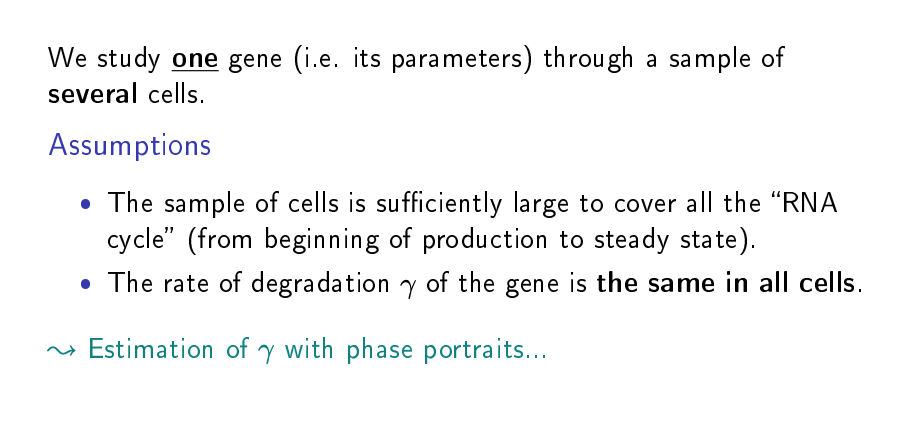


A cross-cell $\gamma$ for each gene was estimated using quantile regression, using cells close to origin and on the upper right corner on the $u\sim s$ phase portrait.
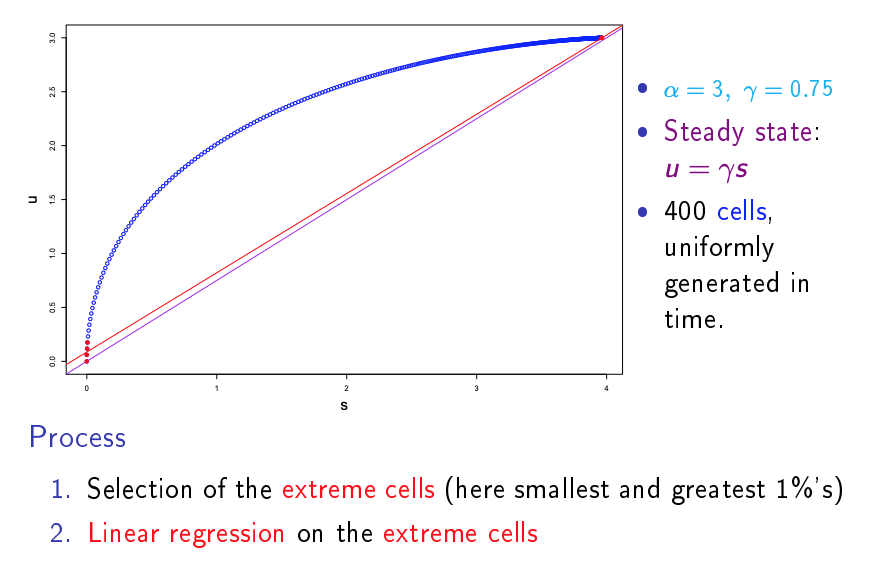

## master equation
Solving rate equations gives the expected level of a RNA species as a function of time. There is another way to model the whole reaction process. We define master equation, which measures the probability of a system to occupy each one of a discrete set of states with regard to a continuous time variable $t$:

$$ \frac{d\vec{P}}{dt}=\mathbf{A}\vec{P},$$ 

which is a PDE that models the change of $P$ over time.

What is $P$? It's a column vector $P(n_1, n_2, ..., n_m; t)$.

Here $(n_1, n_2, ..., n_m)$ denotes a particular state where subjects (say unspliced RNAs) $(N_1, N_2, ..., N_m)$ have the copy number of $(n_1, n_2, ..., n_m)$.

### Exact solution in special cases gives you the full distribution
In the RNA velocity paper, the author reasoned that their reaction model is a open system involving only one type of molecule, and in that special case, the master equation follows or approximates to a poisson distribution. Thus, the exact distribution is given by

$$f(x,y;u,s) = \frac{e^u u^x}{x!} \frac{e^s s^y}{y!}$$

Not very useful in the RNA velocity paper.

### Dynamo: use moments of master equation to estimate parameters

If we have multi-time-series data, which means for each time point we have multiple 4sU labeling events over a short period of time, we can use moment generating function of master equation to estimate unknown parameters.
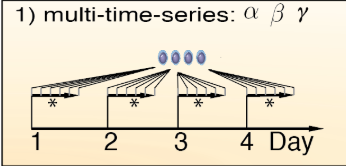

Moment generating function of a random variable $X$ is a special function that can be used to generate moments of $X$.

$${\displaystyle {\begin{aligned}M_{X}(t)=\operatorname {E} (e^{t\,X})&=1+t\operatorname {E} (X)+{\frac {t^{2}\operatorname {E} (X^{2})}{2!}}+{\frac {t^{3}\operatorname {E} (X^{3})}{3!}}+\cdots +{\frac {t^{n}\operatorname {E} (X^{n})}{n!}}+\cdots \\&=1+tm_{1}+{\frac {t^{2}m_{2}}{2!}}+{\frac {t^{3}m_{3}}{3!}}+\cdots +{\frac {t^{n}m_{n}}{n!}}+\cdots ,\end{aligned}}}$$

$m_1$ is the first moment, mean; $m_2$ is the second moment, variance/covariance

First order moment of master equation gives: 4 equations, 4 variables ($a,b \rightarrow \bar \alpha$)

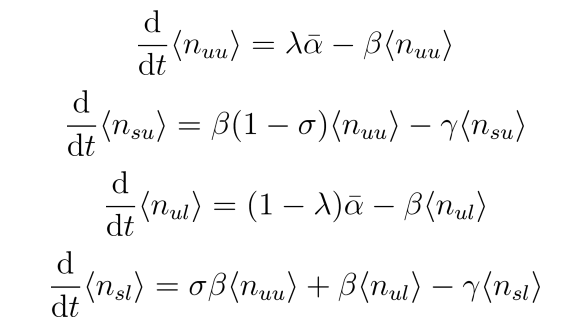

Second order moment of master equation:
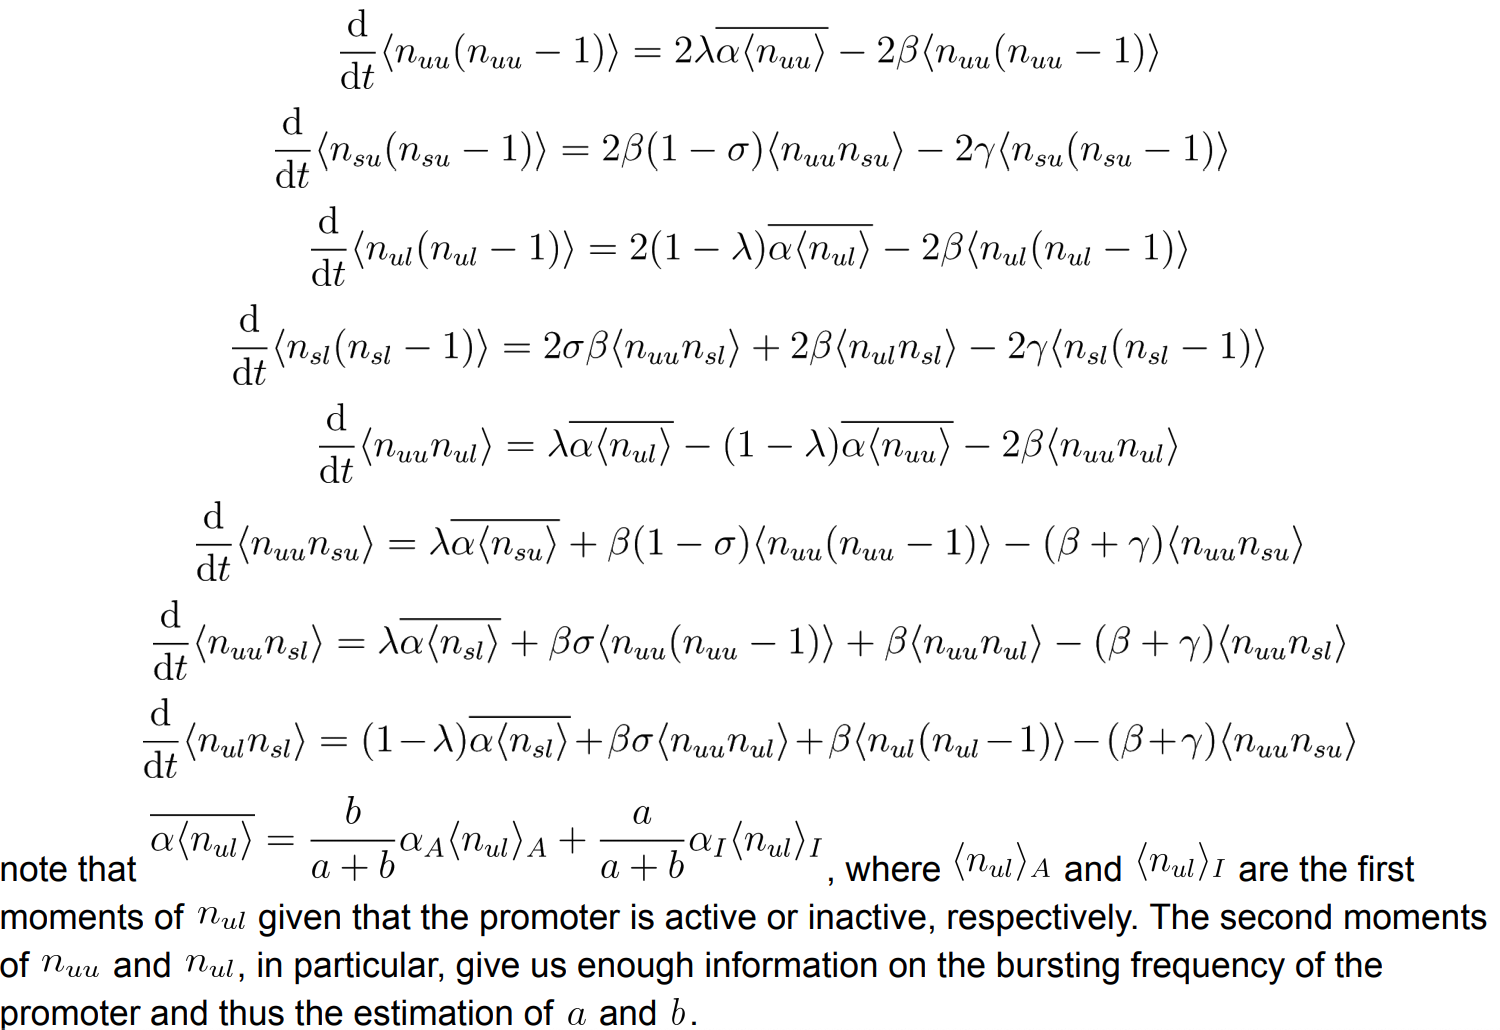

## What's the usage of a reconstructed vector field?

- From a point in the vector space: project the future of a cell
- Analyze the global structure of the vector field: identify stable/unstable fixed points $\rightarrow$ set $X'(t)=F(X(t))=0$

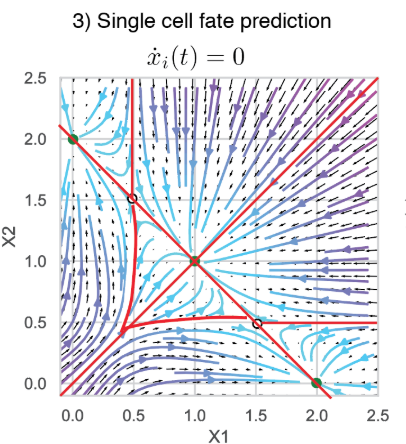

## Reconstruct a vector field using limit vectors
Vector field is specified by a function $f(.)$ which assign a velocity to each point in the gene expression space
$$X'(t) = f(X(t))$$
For each sequenced cell $x_i \in X, i=1,...,N$, the corresponding RNA velocity $y_i=\hat f(x_i)$, have been calculated in the previous steps. Thus, we can using the existing $(x_i, y)$ pairs to fit the vector function $f(.)$.

Since f is a mapping from one vector to another, we need to define the optimization loss on a vector space:
$$L(f) = \Sigma_{i=1}^N \Delta (f(x_i), y) + \lambda \|f\|_{H}^2$$
The first term is the summed error, the second term is a 'ridge penalty' in Hilbert space.

- Reproducing Kernel Hilbert Space https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space
    - Hilbert space: define inner product; completeness
    - Reproducing property: $$
{\displaystyle f(x)=L_{x}(f)=\langle f,\ K_{x}\rangle \quad \forall f\in H.} f(x)=L_{x}(f)=\langle f,\ K_{x}\rangle \quad \forall f\in H.$$
- Representer Theorum https://en.wikipedia.org/wiki/Representer_theorem
$$f^{*}(\cdot )=\sum _{i=1}^{n}\alpha _{i}k(\cdot ,x_{i}),$$

## What's the usage of a reconstructed vector field?
- Numerically map the single cell potential $\rightarrow X'(t) = - \nabla \psi(t)$
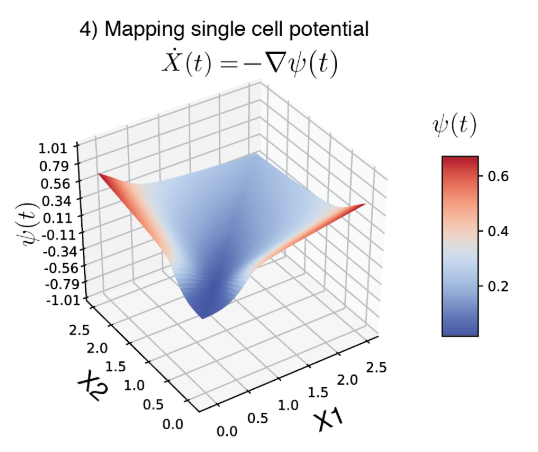

# Appendix

## Why scSLAM-seq might provide better RNA velocity than NTR velocity based on scRNA-seq (From Xiaojie Qiu)
In the scSLAM-seq paper (Erhard et al. 2019), the authors mentioned that they used "new and total RNA levels obtained by scSLAM-seq to replace intronic and exonic read levels and determine ‘NTR velocities’ (personally I think it is still just RNA velocity but takes advantages of metabolic labelling instead of splicing data). And they show that "NTR velocities" produce much better results comparing to splicing data based RNA velocity. However, they didn't provide explicit explanation for this conclusion. In the following, I will try to demonstrate the underlying mathematical reasons (please also check our jupyter notebooks of the application on the recent published NASC-seq dataset (Hendriks et al. 2019)). To start with, if we denote labelled new mRNA as $n$ and total mRNA as $t$, then the above statement essentially replaces the following ODE from RNA velocity paper (La Manno et al. 2018):

$$\dot{s} = \beta u - \gamma s$$

by

$$\dot{t} = n - \gamma t,$$

where $t, n$ are the total mRNA and labelled new mRNA respectively. Note that the amount of labelled new mRNA can be calculated as $\lambda \alpha$ for a fixed time, for example, 1 hour as long as $\alpha$ is the transcription rate corresponds to that time period. $\lambda$ is the rate of labelling for a gene. This equation basically can be read as that the labelled new RNA, like unspliced mRNA represents cell's future state, and will "convert" into current state of total RNA, like spliced mRNA, and that again similar to spliced mRNA, the total RNA will degrade. Under this model, during the labelling period, if the total RNA remains constant, then the newly synthesized (labeled RNA) and the degraded RNA are equal, then we don’t velocity. But if we have more RNA are synthesized (and thus labelled), the velocity is positive and vice versa.

Although the 4sU misincoporation rate for each base T is low (~1.5%), a gene has many copies of T, thus the overal labelling rate for a gene that measured by sequencing adds up and get pretty close to one (> 60%). This capturing rate is significantly higher comparing to the ~20% intron reads in regular scRNA-seq which used in the original RNA velocity paper. Thus RNA velocity based on scSLAM-seq data is dramatically better than the splicing only data.

## Reference
1. **Extrodinary material for visually understand ODE and PDE**

https://www.youtube.com/watch?v=p_di4Zn4wz4&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6

2. Dynamo/scSLAM-seq paper: 

https://www.biorxiv.org/content/biorxiv/early/2019/07/09/696724.full.pdf

3. RNA velocity paper:

https://www.nature.com/articles/s41586-018-0414-6

https://orbi.uliege.be/bitstream/2268/230991/1/RNA%20Velocity%20-%20Presentation.pdf